# Modelling of chip probabilities

In [51]:
import pandas, geopandas
import os, json

from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import chip_prob_modelling as tools

## Data

### Probabilities

Probabilities for each category by chip, as produced by the neural network:

In [2]:
probs = geopandas.read_parquet('32_nw_pred.parquet')

We also keep the names of all classes separate and semantically sorted as it'll come in handy afterwards:

In [3]:
tools.class_names

['urbanity',
 'dense_urban_neighbourhoods',
 'dense_residential_neighbourhoods',
 'connected_residential_neighbourhoods',
 'gridded_residential_quarters',
 'accessible_suburbia',
 'disconnected_suburbia',
 'open_sprawl',
 'warehouse_park_land',
 'urban_buffer',
 'countryside_agriculture',
 'wild_countryside']

### Labels

Proportions of observed classes per chip. They are aligned with `probs` so we can remove the `geometry` column.

In [4]:
labels = pandas.read_parquet(
    'chip_proportions.pq'
).drop('geometry', axis=1)

These are encoded in following a grouping described in the JSON model file:

In [5]:
cd2nm = tools.parse_nn_json('efficientnet_pooling_256_12.json')

We replace the code in `labels` by the name and aggregate by column names so we have the proportions in each chip by name rather than code:

In [6]:
relabels = labels.rename(columns=cd2nm).groupby(level=0, axis=1).sum()

`relabels` contains a few rows with a total probability sum of 0: these are chips that fall within the water. We remove them:

In [7]:
relabels_nw = relabels[relabels.sum(axis=1) > 0.5] # 0.5 to avoid rounding errors

To begin with, we focus on single class chips. We identify which are single class:

In [8]:
single_class = relabels_nw.where(relabels_nw==1).sum(axis=1).astype('bool')
single_class.sum() * 100 / single_class.shape[0] # Pct single class

66.80763900211969

And then pull the class for each of them:

In [9]:
label = pandas.Categorical(relabels_nw.idxmax(axis=1))

### Build `db_all`

Single table with probabilities, labels and single-class flag:

In [10]:
db_all = probs.join(
    pandas.DataFrame({'label': label, 'single_class': single_class})
)
db_all['single_class'] = db_all['single_class'].fillna(False)

Note not all chips have a `label` and `single_class` value. To make sure they are consistent, we replace the `N/A` in `single_class` by a `False`.

### Train/Validation split

Next, we split the sample into train and validation sets. The training split proportion is set by the global parameter `TRAIN_FRAC`.

In [11]:
db_all['train_all'] = False
db_all.loc[
    db_all.sample(frac=TRAIN_FRAC, random_state=1234).index, 'train_all'
] = True

### Spatial lag


#### Overview


Some models will include spatial context. Here we calculate these measures through the spatial lag of the probability for each class. Given we are in a train/validation split context, there are two ways to approach the construction of the lag:

1. [`wa`] Absolute lag: we first calculate the lag for each chip, then split between train/validation. This ensures the lag is representative of the geographic context on the ground, but runs the risk of spilling information between train and validation samples. We say here "runs the risk" because the validation chips are _not_ used as focal chips for training and thus the model does not "see" them as such. However, validation chips are _also_ seen by the model as context, and that does make information cross between the sets. We consider this option as a way to explore the extent of this issue. One complication is that this approach also provides more information about geographic context. In the vent these models had higher performance (likely), it might not be clear which source is driving the boost: the better representation of geographic context, or the information cross-over between train and validation sets.
1. [`ws`] Split lag: here we start by splitting the set into train/validation and then we calculate the spatial lag separately. This is a cleaner way to assess performance, but also one that distorts geographical context so might potentially perform worse than a model that could include a better representation.
1. [`wbs`] Block split lag: here we use a different train/validation split that relies on blocks of 3x3 chips to not be separated. Also, we only use focal chips for model fitting and evaluation. This ensures a clean cut between train/val _and_ full geographic context, at the expense of less observations in the model.

After discussions, we have decided to start with `ws`. Upon further reflection, `wa` implies a clear case of "leakage" of information from the validation into the training sets, and thus "pollutes" the estimates of accuracy. The `wbs` remains valid but two caveats apply: a) a proper implementation of the approach results in an important loss of observations (for every 3x3 block of chips, only one of them enters the modeling), and this probably has an important effect on smaller classes such as the urbanities; b) at a theoretical level, it is still not clear it's the preferred approach (see [Wadoux et al. 2021](https://www.sciencedirect.com/science/article/pii/S0304380021002489?via=ihub); for context). On this last point, my (DA-B) sense is that it still makes sense to block in smaller chunks and split those between train and validation because you want to ensure that the effect of context is characterised adequately, and the risk of not picking up the variation desired in both training and validation sets (the main concern of Wadoux et al. 2021) is lessened by blocking at a relatively small scale and randomly sampling from those

#### Split lag

In [15]:
lag_all = db_all.groupby('train_all').apply(
    tools.lag_columns, cols=tools.class_names
)

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4895 disconnected components.
 There are 1771 islands with ids: 11, 13, 14, 15, 28, 44, 46, 52, 53, 66, 71, 140, 156, 175, 185, 189, 195, 209, 219, 292, 293, 333, 342, 359, 398, 425, 432, 436, 452, 477, 480, 481, 521, 537, 561, 582, 596, 597, 599, 627, 629, 654, 656, 688, 804, 841, 860, 885, 896, 936, 975, 1001, 1010, 1074, 1140, 1149, 1181, 1182, 1183, 1185, 1186, 1197, 1198, 1218, 1227, 1228, 1229, 1230, 1272, 1273, 1284, 1294, 1296, 1300, 1346, 1357, 1386, 1408, 1413, 1489, 1502, 1503, 1509, 1518, 1519, 1521, 1541, 1564, 1595, 1603, 1612, 1707, 1710, 1711, 1754, 1868, 1870, 1874, 1884, 1894, 1921, 1942, 1943, 1953, 1955, 1956, 1957, 1965, 1969, 1981, 1985, 2032, 2036, 2067, 2105, 2120, 2121, 2125, 2126, 2133, 2166, 2187, 2206, 2217, 2220, 2226, 2228, 2280, 2325, 2337, 2352, 2372, 2386, 2435, 2449, 2457, 2473, 2480, 2492, 2515, 2533, 2560, 2561, 

('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 66, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 156, ' is an island (no neighbors)')
('WARNING: ', 175, ' is an island (no neighbors)')
('WARNING: ', 185, ' is an island (no neighbors)')
('WARNING: ', 189, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 209, ' is an island (no neighbors)')
('WARNING: ', 219, ' is an island (no neighbors)')
('WARNING: ', 292, ' is an island (no neig

NameError: name 'np' is not defined

To make things handier later, we grab the names of the lagged variables separately:

In [18]:
w_class_names = ['w_'+i for i in tools.class_names]

Spatially lagging the split chips will give rise to islands (chips that do not have any neighbors). This will mean later on, when we consolidate the table for models, we will have to drop island observations and, if there is a systematic bias in the group (train/val) where we drop more, it might induce further issues down the line.

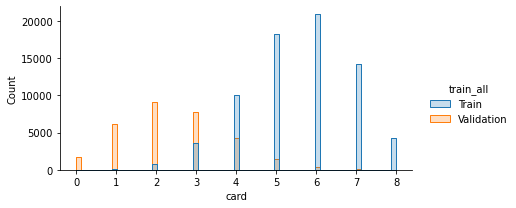

In [19]:
sns.displot(
    lag_all.assign(
        train_all=db_all['train_all'].map({True: "Train", False: "Validation"})
    ), 
    x='card', 
    hue='train_all', 
    element='step',
    aspect=2,
    height=3
);

Cardinalities clearly differ: trainining observations (a larger group) has more neighbors on average. This is potentially a problem in that the validation set is _not_ mimmicking the training one. However, the direction of the difference might be such that evaluation metrics could be taken as a _lower_ bound: the model is trained using more information from context but evaluated with less; performance will be evaluated with "worse" conditions than it's been trained on so, everything else being equal, it'd give lower scores than the model actually should.

**DA-B**: discuss with MF it is the case

In [25]:
corrs = tools.build_prob_wprob_corrs(
    tools.class_names, w_class_names, db_all, lag_all
)

As an exploration, here we have the correlation between high probability in a given class, and high probability in other classes in the spatial lag (geographic context). There is a clear pattern of non-zero correlations.

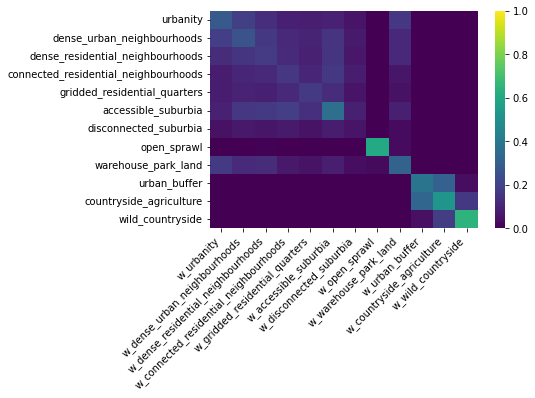

In [26]:
h = sns.heatmap(corrs, vmin=0, vmax=1, cmap='viridis')
h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right");

#### Block Split lag

`[TBA]`

### Interaction variables

Here we develop a set of interaction variables between the probability of each class and their spatial lag. In mathematical terms, the expected probability $\mu_i$ for chip $i$ in our base model is:

$$
\mu_i = \alpha + \sum_k  P_{ki} \beta_k
$$

When we include the spatial lag, this becomes:

$$
\mu_i = \alpha + \sum_k  P_{ki} \beta_k + \sum_k WP_{ki} \gamma_k
$$

The idea with interactions is to model the probability expectation as:

$$
\mu_i = \alpha + \sum_k  P_{ki} \beta_k + \sum_k WP_{ki} \gamma_k + \sum_k \sum_k P_{ki} \times WP_{ki} \delta_{kk}
$$


Here we build a method to construct the last term in the equation above ($\sum_k \sum_k P_{ki} \times WP_{ki}$), which will be used when fitting some of the models below:

### Build `db`

Finally, we bring together in a single, clean table information on the original probabilities, their spatial lags, and class label. To make sure it is analysis-ready, we retain only single-class chips that are _not_ islands (i.e., have at least one neighbor).

In [32]:
db = db_all.join(
    lag_all
).query(
    '(single_class == True) & (island == False)'
).drop(['single_class', 'island'], axis=1)

The dropping of observations that happened above might also induce additional biases.

**DA-B** Explore further the distribution of values between train/val sets (e.g. heatmaps/hists before the split and after)

### Extract train/val indices

Now we have the set ready, we can pick out train/val indices as the modeling will expect them.

In [33]:
train_ids = db.query('train_all == True').index
val_ids = db.query('train_all == False').index

### Class (im)balance

The spatial lag step might be introducing bias in the sample before modelling. We pick all the single class chips and split them randomly between train and validation. If spatially lagging has a systematic effect on some classes (e.g., some classes get dropped more often), this might introduce bias that will make our model scoress unreliable. To explore this case, we want to get an idea of:

- [x] Overall proportion of train/val before (`db_all` single class) and after spatially lagging (`db`)


In [34]:
pandas.DataFrame(
    {
        'before_lag': db_all.query('single_class').value_counts(
            'train_all'
        ) * 100 / len(db_all.query('single_class')),
        'after_lag': db.value_counts('train_all') * 100 / len(db)
    }
).rename({True: 'Training', False: 'Validation'})

,before_lag,after_lag
train_all,,
Training,70.116082,71.35183
Validation,29.883918,28.64817


- [x] Poportion by class in the set before spatially lagging and after --> `Fig. Balance (b)`

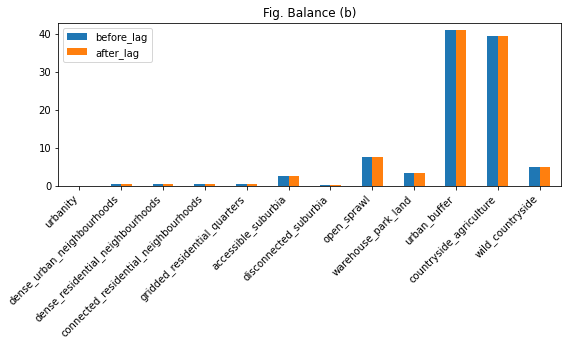

In [36]:
props = pandas.DataFrame(
    {
        'before_lag': pandas.value_counts(
            db_all.query('single_class')['label']
        ) * 100 / len(db_all.query('single_class')),
        'after_lag': pandas.value_counts(
            db['label']
        ) * 100 / len(db['label'])
    }
)

p = props.reindex(tools.class_names).plot.bar(figsize=(9, 3), title='Fig. Balance (b)')
p.set_xticklabels(p.get_xticklabels(), rotation = 45, ha="right");

## Single class models


Models to evaluate:

| Algorithm / Features | Baseline | Baseline + $WX$ | Baseline + $WX$ + $X\times WX$ |
|----------------------|----------|-----------------|-----------------|
| Max. Prob            | `mp_res` |       N/A       |       N/A       |
| Logit ensemble       | `logite_baseline_res` | `logite_wx_res` | Singular matrix |
| MNLogit              | Does not converge | Does not converge | -  |
| Random Forest        | `rf_baseline_res` | `rf_wx_res` | N/A |
| XGBoost              | `hbgb_baseline_res` | `hbgb_wx_res` | N/A |

Evaluation workflow:

1. Split train/validation randomly (e.g., 70/30)
1. Fit model on train subset
1. Obtain `perf_` measures on validation subset
1. Fill `results.json` file

Format:

```json
{
    "meta_n_class": <int>,
    "meta_class_names": <list>,
    "meta_trainval_counts": <dict>
    "model_name": <str>,
    "model_params": <list>,
    "meta_runtime": <float>,
    "perf_model_accuracy_train": <float>,
    "perf_within_class_accuracy_train": <list>,
    "perf_confusion_train": <list>,    
    "perf_model_accuracy_val": <float>,
    "perf_within_class_accuracy_val": <list>,
    "perf_confusion_val": <list>,
    "notes": <str>,
}
```

### Max. Probability

This is a baseline that selects as predicted category that which displays the highest probability as stored in `probs`. We can consider this the baseline upon which other models will improve.

In [47]:
mp_res = tools.run_maxprob(
    tools.class_names, 'label', db, train_ids, val_ids, 'baseline', 'model_results/'
)

### Logit ensemble

Our approach here consists on fitting individual logistic regressions to predict each class against all other ones. With these models, we obtain a probability for each class, and pick that with the largest one as the predicted class.

---

**NOTE (DA-B)**: this might not be right if different logits have different distribution of probabilities. Maybe replace the probability by the rank and pick the largest rank as the predicted class?

---

Two methods, `logite_fit` to fit each class model, and `logite_predict` to generate predicted classes from set of arbitrary features.

#### Baseline

In [53]:
logite_baseline_res = tools.run_logite(
    tools.class_names, 'label', db, train_ids, val_ids, 'baseline', 'model_results/'
)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Optimization terminated successfully.
         Current function value: 0.680899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692743
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691024
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693131
  

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


#### Baseline + $WX$

In [54]:
logite_wx_res = tools.run_logite(
    tools.class_names + w_class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    'baseline_wx', 
    'model_results/'
)

Optimization terminated successfully.
         Current function value: 0.657119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.604344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692461
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692309
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692096
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692777
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693107
  

#### Baseline + $WX$ + $X\times WX$

In [ ]:
logite_xwx_res = tools.run_logite(
    tools.class_names + w_class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    'baseline_wx_xwx', 
    'model_results/',
    scale_x=False,
    log_x=True,
    interact=(tools.class_names, w_class_names)
)

### Multinomial Logit



For this we rely on `statsmodels` [implementation](https://www.statsmodels.org/stable/examples/notebooks/generated/discrete_choice_overview.html#Multinomial-Logit) and fit it to the standardised log of the original probabilities to make convergence possible:

In [35]:
X_train = pandas.DataFrame(
    scale(np.log1p(db.loc[train_ids, class_names+w_class_names])), train_ids, class_names+w_class_names
)
t0 = time()
mlogit_mod = sm.MNLogit(db.loc[train_ids, 'label'], X_train)
mlogit_res = mlogit_mod.fit()

/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2299: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2300: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 9


In [56]:
from importlib import reload
reload(tools);

#### Baseline

In [57]:
mlogit_res = tools.run_mlogit(
    tools.class_names, 'label', db, train_ids, val_ids, 'baseline', 'model_results/'
)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2299: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:2300: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 5


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### Baseline + $WX$

In [ ]:
mlogit_wx = tools.run_mlogit(
    tools.class_names + w_class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    'baseline', 
    'model_results/'
)

### Random Forest

In [58]:
rf_param_grid = {
    'n_estimators': [150],
    'max_depth': [5],
    'max_features': [0.25, 'sqrt']
}

In [59]:
rf_param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [5, 10, 20, 30, None],
    'max_features': [0.25, 0.5, 0.75, 1, 'sqrt', 'log2']
}

#### Baseline

- Grid search

In [37]:
%%time 
grid = GridSearchCV(
    RandomForestClassifier(),
    rf_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid.fit(
    db.query('train_all')[tools.class_names], 
    db.query('train_all')['label']
)
pandas.DataFrame(grid.cv_results_).to_csv(
    'model_results/RandomForestClassifier_baseline.csv'
)
print(grid.best_params_)

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 5, 'max_features': 0.25, 'n_estimators': 100}
CPU times: user 6.2 s, sys: 890 ms, total: 7.09 s
Wall time: 20min 32s


- Model fitting

In [38]:
rf_baseline_res = tools.run_tree(
    tools.class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    RandomForestClassifier(**grid.best_params_),
    'baseline', 
    'model_results/'
)

#### Baseline + $WX$

- Grid search

In [39]:
%%time
grid = GridSearchCV(
    RandomForestClassifier(),
    rf_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid.fit(
    db.query('train_all')[tools.class_names + w_class_names], 
    db.query('train_all')['label']
)
pandas.DataFrame(grid.cv_results_).to_csv(
    'model_results/RandomForestClassifier_baseline_wx.csv'
)
print(grid.best_params_)

/opt/conda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
CPU times: user 30.4 s, sys: 402 ms, total: 30.8 s
Wall time: 34min


- Model fitting

In [40]:
rf_wx_res = tools.run_tree(
    tools.class_names + w_class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    RandomForestClassifier(**grid.best_params_),
    'baseline_wx', 
    'model_results/'
)

### Histogram-Based Gradient Boosting

See [documentation](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting) for the meaning and approaches to the hyper-parameters.

In [166]:
hbgb_param_grid = {
    'max_iter': [50],
    'learning_rate': [0.01, 0.05],
    'max_depth': [30, None],
}

In [41]:
hbgb_param_grid = {
    'max_iter': [50, 100, 150, 200, 300],
    'learning_rate': [0.01, 0.05] + np.linspace(0, 1, 11)[1:].tolist(),
    'max_depth': [5, 10, 20, 30, None],
}

#### Baseline

- Grid search:

In [42]:
%%time
grid = GridSearchCV(
    HistGradientBoostingClassifier(),
    hbgb_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid.fit(
    db.query('train_all')[tools.class_names], db.query('train_all')['label']
)
pandas.DataFrame(grid.cv_results_).to_csv(
    'model_results/HistGradientBoostingClassifier_baseline.csv'
)
print(grid.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 200}
CPU times: user 1min 56s, sys: 1.11 s, total: 1min 57s
Wall time: 4min 22s


- Model fitting

In [43]:
hbgb_baseline_res = tools.run_tree(
    tools.class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    HistGradientBoostingClassifier(**grid.best_params_),
    'baseline', 
    'model_results/'
)

#### Baseline + $WX$

- Grid search:

In [44]:
%%time
grid = GridSearchCV(
    HistGradientBoostingClassifier(),
    hbgb_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid.fit(
    db.query('train_all')[tools.class_names + w_class_names], 
    db.query('train_all')['label']
)
pandas.DataFrame(grid.cv_results_).to_csv(
    'model_results/HistGradientBoostingClassifier_baseline_wx.csv'
)
print(grid.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 150}
CPU times: user 1min 32s, sys: 933 ms, total: 1min 33s
Wall time: 6min 23s


- Model fitting

In [45]:
hbgb_wx_res = tools.run_tree(
    tools.class_names + w_class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    HistGradientBoostingClassifier(max_iter=100),
    'baseline_wx', 
    'model_results/'
)

---

**NOTE** - As of April 21st'22, standard gradient-boosted trees are deprecated due to their long training time and similar performance with histogram-based ones.

### Gradient Tree Boosting

See [documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting) for the meaning and approaches to the hyper-parameters (mostly `n_estimators` and `learning_rate`).

#### Baseline

In [310]:
gbt_baseline_res = run_tree(
    class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    GradientBoostingClassifier(n_estimators=50, learning_rate=1.),
    'baseline', 
    'model_results/'
)

#### Baseline + $WX$

In [311]:
gbt_baseline_res = run_tree(
    class_names + w_class_names, 
    'label', 
    db, 
    train_ids, 
    val_ids, 
    GradientBoostingClassifier(n_estimators=50, learning_rate=1.),
    'baseline_wx', 
    'model_results/'
)